In [9]:
# Bibliotecas
import pandas            as pd    # Biblioteca para trabajar con DataFrames
import numpy             as np    # Biblioteca para trabajar con àlgebra lineal
import matplotlib.pyplot as plt   # Biblioteca para realizar gràficas
import seaborn           as sns   # Biblioteca para realizar gràficas
import statsmodels.api   as sm    # Biblioteca para realizar algunos modelos estadisticos

from sklearn.linear_model import LinearRegression, Ridge  # Función para realizar un modelo de regresiòn lineal
from scipy.optimize       import minimize                 # Función para encontrar minimos locales de una funciòn

# Modelos Disponiboles
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
# modelo_ols   = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
# modelo_ridge = Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, \
#                      tol=0.001, solver="auto", random_state=None)

sns.set()

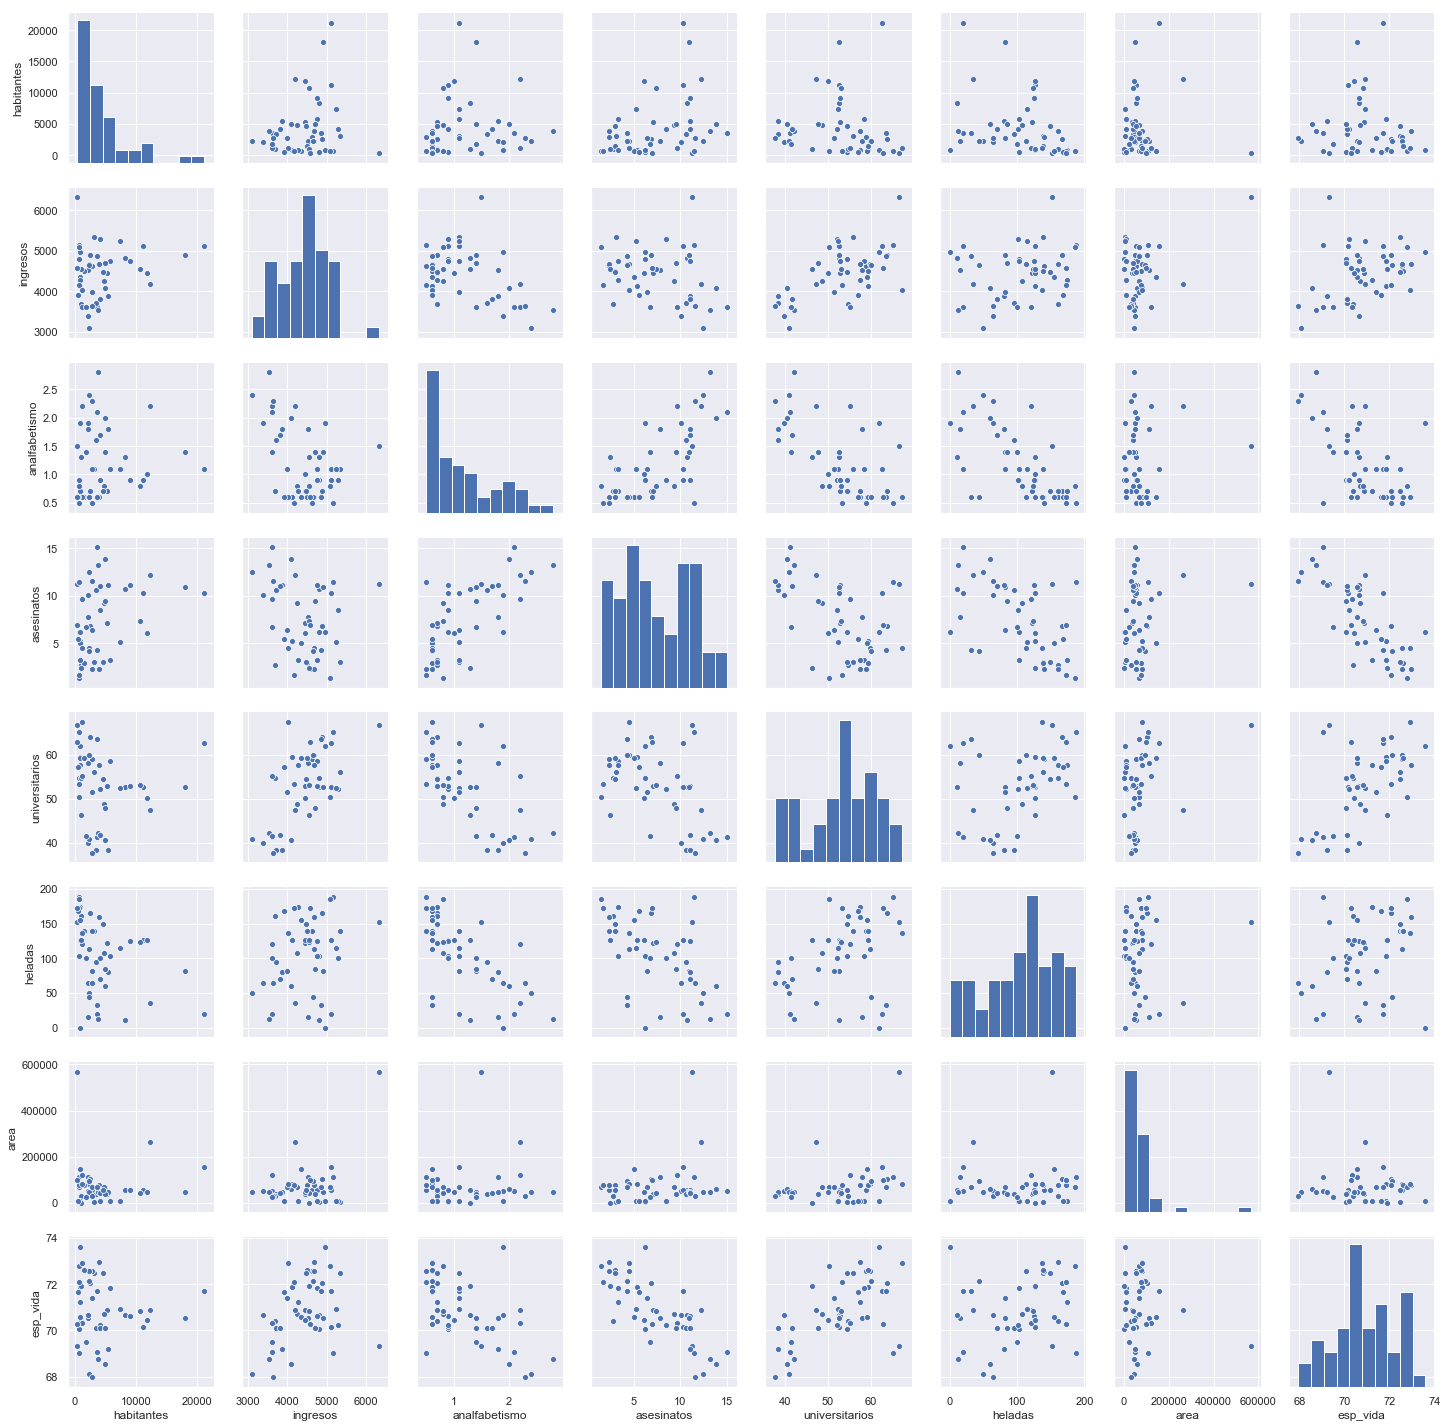

         habitantes     ingresos  analfabetismo  asesinatos  universitarios  \
count     50.000000    50.000000      50.000000    50.00000       50.000000   
mean    4246.420000  4435.800000       1.170000     7.37800       53.108000   
std     4464.491433   614.469939       0.609533     3.69154        8.076998   
min      365.000000  3098.000000       0.500000     1.40000       37.800000   
25%     1079.500000  3992.750000       0.625000     4.35000       48.050000   
50%     2838.500000  4519.000000       0.950000     6.85000       53.250000   
75%     4968.500000  4813.500000       1.575000    10.67500       59.150000   
max    21198.000000  6315.000000       2.800000    15.10000       67.300000   

          heladas           area   esp_vida  
count   50.000000      50.000000  50.000000  
mean   104.460000   70735.880000  70.878600  
std     51.980848   85327.299622   1.342394  
min      0.000000    1049.000000  67.960000  
25%     66.250000   36985.250000  70.117500  
50%    114.5

In [13]:
datos_state  = pd.read_csv("state_77.csv")       # Datos State 77
sns.pairplot(data=datos_state)
plt.show()

print( datos_state.describe() )

## Regresión Múltiple :: Datos State

In [14]:
datos_state.head()

,estado,habitantes,ingresos,analfabetismo,asesinatos,universitarios,heladas,area,esp_vida
0,Alabama,3615,3624,2.1,15.1,41.3,20,50708,69.05
1,Alaska,365,6315,1.5,11.3,66.7,152,566432,69.31
2,Arizona,2212,4530,1.8,7.8,58.1,15,113417,70.55
3,Arkansas,2110,3378,1.9,10.1,39.9,65,51945,70.66
4,California,21198,5114,1.1,10.3,62.6,20,156361,71.71


In [15]:
# Se pretende estimar la esperanza de vida
X = datos_state.iloc[:,1:8].values
Y = datos_state.iloc[:,  8].values

print("Matriz de Diseño ::")
print(X[0:5,:])
print("")
print("Y Real ::")
print(Y[0:5])

Matriz de Diseño ::
[[3.61500e+03 3.62400e+03 2.10000e+00 1.51000e+01 4.13000e+01 2.00000e+01
  5.07080e+04]
 [3.65000e+02 6.31500e+03 1.50000e+00 1.13000e+01 6.67000e+01 1.52000e+02
  5.66432e+05]
 [2.21200e+03 4.53000e+03 1.80000e+00 7.80000e+00 5.81000e+01 1.50000e+01
  1.13417e+05]
 [2.11000e+03 3.37800e+03 1.90000e+00 1.01000e+01 3.99000e+01 6.50000e+01
  5.19450e+04]
 [2.11980e+04 5.11400e+03 1.10000e+00 1.03000e+01 6.26000e+01 2.00000e+01
  1.56361e+05]]

Y Real ::
[69.05 69.31 70.55 70.66 71.71]


In [16]:
# Modelos tradicionales
modelo_ols   = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None).fit(X, Y)
modelo_ridge = linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None,
                                  tol=0.001, solver="auto", random_state=None).fit(X, Y)
y_estimadas_ols   = modelo_ols.predict(   X )
y_estimadas_ridge = modelo_ridge.predict( X )
print("Score OLS   ->", modelo_ols.score( X, Y ) )
print("Score Ridge ->", modelo_ridge.score( X, Y ) )

Score OLS   -> 0.736156268908904
Score Ridge -> 0.7361488318702212


In [17]:
# Modelo por optimización
def CrearModeloOptimizado( X, Y, intercepto=True ):
    X , Y = X, Y
    n     = len(X)
    
    # Lo transformo a una matriz de nx1, o si tiene intercepto, a una matriz de nx2
    # De esta manera, X es la matriz de diseño
    if intercepto == True:
        X = np.matrix( np.stack( (np.ones(n), X), axis=-1) )
    else: 
        X = np.matrix( X.reshape( (n,1) ) )
    
    Y           = np.matrix( Y.reshape( (n,1) ) )
    hat         = X * np.linalg.inv( X.T * X ) * X.T
    influencia  = np.diag(hat)
    rango       = np.sum( influencia )
    atipicos    = influencia > 2*rango/n
    
    def f_costo(arreglo_a_optimizar):
        tam_arreglo = len(arreglo_a_optimizar)
        betas, lam  = arreglo_a_optimizar[0:(tam_arreglo-1)], arreglo_a_optimizar[tam_arreglo] 
        betas       = np.matrix( betas.reshape( (n,1) ) )
        y_estimadas = X * betas
        costo_1     = np.mean( np.power( Y - y_estimadas, 2 ) )
        costo_2     = lam * np.sum( np.power( betas[1:n], 2 ) )
        return( costo_1 + costo_2 )
    
    betas = minimize( fun = f_costo, x0 = np.array(), tol = 0.001, constraints=({'type':'ineq', 'fun': lambda x:x}), bounds=((0,None)) )
    print( betas )
    
CrearModeloOptimizado( X, Y )

ValueError: all input arrays must have the same shape

In [142]:
Y

array([69.05, 69.31, 70.55, 70.66, 71.71, 72.06, 72.48, 70.06, 70.66,
       68.54, 73.6 , 71.87, 70.14, 70.88, 72.56, 72.58, 70.1 , 68.76,
       70.39, 70.22, 71.83, 70.63, 72.96, 68.09, 70.69, 70.56, 72.6 ,
       69.03, 71.23, 70.93, 70.32, 70.55, 69.21, 72.78, 70.82, 71.42,
       72.13, 70.43, 71.9 , 67.96, 72.08, 70.11, 70.9 , 72.9 , 71.64,
       70.08, 71.72, 69.48, 72.48, 70.29])

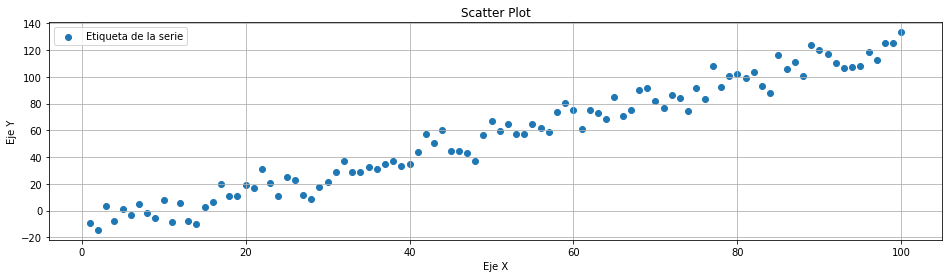

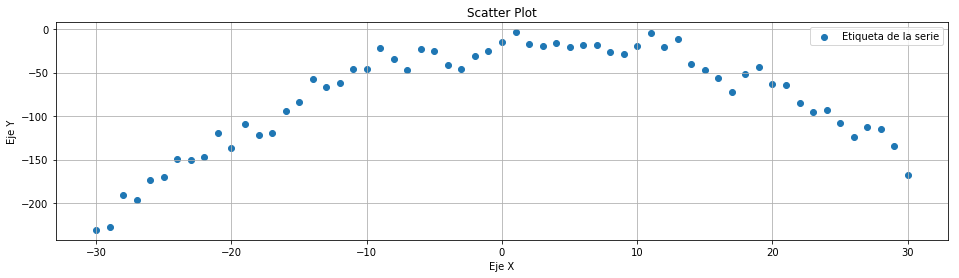

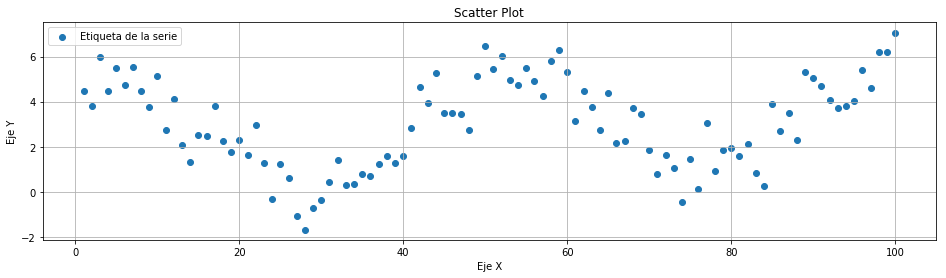

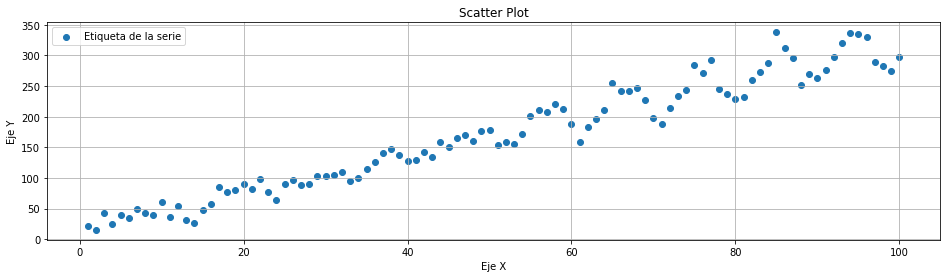

In [4]:
datos_1     = pd.read_csv("datos_ajuste_1.csv") # Y = -15 + np.sqrt(2)*X 
datos_2     = pd.read_csv("datos_ajuste_2.csv") # Y = -15 + np.sqrt(2)*X - 0.2*X**2
datos_3     = pd.read_csv("datos_ajuste_3.csv") # Y = 2 + 0.02*X + np.sqrt(2)*np.sin(2*np.pi*X/48) + np.sqrt(3)*np.cos(2*np.pi*X/48)
datos_4     = pd.read_csv("datos_ajuste_4.csv") # Y = 12 + np.pi*X + 0.5*X*np.cos(2/3*X)
if True:
    for datos in [datos_1, datos_2, datos_3, datos_4]:
        X, Y = np.array( datos["X"] ), np.array( datos["Y"] )  # Leemos los datos y los transformamos a arreglos
        X    = X.reshape( (len(X),1) )                         # Lo transformo a una matriz de nx1
        plt.figure( figsize=(16,4) )                           # Indicamos el tamaño de la gráfica
        plt.title("Scatter Plot")                              # Añadimos el titulo
        plt.scatter( X, Y , label = "Etiqueta de la serie" )   # Añadimos la 'capa' de puntos 
        plt.xlabel("Eje X")                                    # Modificamos la etiqueta del eje X
        plt.ylabel("Eje Y")                                    # Modificamos la etiqueta del eje Y
        plt.grid()                                             # Añadimos una cuadricula/rendija 
        plt.legend()                                           # Añadimos un cuadro con la leyenda
        plt.show()                                             # Indicamos que queremos mostrar la gráfica

In [5]:
def CrearModeloOLS( datos, intercepto=True, grafica=False, prueba_normalidad=True ):
    X, Y = np.array( datos["X"] ), np.array( datos["Y"] )  # Leemos los datos y los transformamos a arreglos
    n    = len(X)                                          # Tamaño de la muestra
    
    # Graficamos los datos
    if grafica == True:
        plt.figure( figsize=(16,4) )                           # Indicamos el tamaño de la gráfica
        plt.title("Scatter Plot")                              # Añadimos el titulo
        plt.scatter( X, Y , label = "Etiqueta de la serie" )   # Añadimos la 'capa' de puntos 
        plt.xlabel("Eje X")                                    # Modificamos la etiqueta del eje X
        plt.ylabel("Eje Y")                                    # Modificamos la etiqueta del eje Y
        plt.grid()                                             # Añadimos una cuadricula/rendija 
        plt.legend()                                           # Añadimos un cuadro con la leyenda
        plt.show()                                             # Indicamos que queremos mostrar la gráfica

    # Lo transformo a una matriz de nx1, o si tiene intercepto, a una matriz de nx2
    # De esta manera, X es la matriz de diseño
    if intercepto == True:
        X = np.matrix( np.stack( (np.ones(n), X), axis=-1) )
    else: 
        X = np.matrix( X.reshape( (n,1) ) )
    
    Y           = np.matrix( Y.reshape( (n,1) ) )
    betas       = np.linalg.inv( X.T * X ) * X.T * Y
    hat         = X * np.linalg.inv( X.T * X ) * X.T
    influencia  = np.diag(hat)
    rango       = np.sum( influencia )
    atipicos    = influencia > 2*rango/n
    y_estimadas = X * betas
    residuales  = Y - y_estimadas
    f_costo     = np.mean( np.power( Y - y_estimadas, 2 ) )
    
    if prueba_normalidad == True:
        pass
    
    return( y_estimadas )

### Datos 1

In [ ]:
X, Y = np.array( datos_1["X"] ), np.array( datos_1["Y"] )  # Leemos los datos y los transformamos a arreglos
X    = X.reshape( (len(X),1) )
    
modelo_ols   = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None).fit(X, Y)
modelo_ridge = linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None,
                                  tol=0.001, solver="auto", random_state=None).fit(X, Y)

y_estimadas_mh    = np.array( CrearModeloOLS( datos_1 ) )
y_estimadas_ols   = modelo_ols.predict( X )
y_estimadas_ridge = modelo_ridge.predict( X )


plt.figure( figsize=(16,4) )                           # Indicamos el tamaño de la gráfica
plt.title("Scatter Plot")                              # Añadimos el titulo
plt.scatter( X, Y , label = "Etiqueta de la serie" )   # Añadimos la 'capa' de puntos 
plt.plot( X, y_estimadas_mh ,    label = "MH" )        # Añadimos la 'capa' de puntos 
plt.plot( X, y_estimadas_ols ,   label = "OLS" )       # Añadimos la 'capa' de puntos 
plt.plot( X, y_estimadas_ridge , label = "Ridge" )     # Añadimos la 'capa' de puntos 
plt.xlabel("Eje X")                                    # Modificamos la etiqueta del eje X
plt.ylabel("Eje Y")                                    # Modificamos la etiqueta del eje Y
plt.grid()                                             # Añadimos una cuadricula/rendija 
plt.legend()                                           # Añadimos un cuadro con la leyenda
plt.show()                                             # Indicamos que queremos mostrar la gráfica
        

### Datos 2

In [ ]:
X, Y = np.array( datos_2["X"] ), np.array( datos_2["Y"] )  # Leemos los datos y los transformamos a arreglos
X    = X.reshape( (len(X),1) )
    
modelo_ols   = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None).fit(X, Y)
modelo_ridge = linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None,
                                  tol=0.001, solver="auto", random_state=None).fit(X, Y)

y_estimadas_mh    = np.array( CrearModeloOLS( datos_2 ) )
y_estimadas_ols   = modelo_ols.predict( X )
y_estimadas_ridge = modelo_ridge.predict( X )


plt.figure( figsize=(16,4) )                           # Indicamos el tamaño de la gráfica
plt.title("Scatter Plot")                              # Añadimos el titulo
plt.scatter( X, Y , label = "Etiqueta de la serie" )   # Añadimos la 'capa' de puntos 
plt.plot( X, y_estimadas_mh ,    label = "MH" )        # Añadimos la 'capa' de puntos 
plt.plot( X, y_estimadas_ols ,   label = "OLS" )       # Añadimos la 'capa' de puntos 
plt.plot( X, y_estimadas_ridge , label = "Ridge" )     # Añadimos la 'capa' de puntos 
plt.xlabel("Eje X")                                    # Modificamos la etiqueta del eje X
plt.ylabel("Eje Y")                                    # Modificamos la etiqueta del eje Y
plt.grid()                                             # Añadimos una cuadricula/rendija 
plt.legend()                                           # Añadimos un cuadro con la leyenda
plt.show()                                             # Indicamos que queremos mostrar la gráfica